In [1]:
%%capture
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade


In [9]:
!pip install super-gradients

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 18.5 MB/s eta 0:00:00
  Using cached boto3-1.28.78-py3-none-any.whl (135 kB)
  Using cached Deprecated-1.2.14-py2.py3-none-any.whl (9.6 kB)
  Using cached coverage-5.3.1-cp310-cp310-linux_x86_64.whl
  Using cached Sphinx-4.0.3-py3-none-any.whl (2.9 MB)
  Using cached sphinx_rtd_theme-1.3.0-py2.py3-none-any.whl (2.8 MB)
  Using cached torchmetrics-0.8.0-py3-none-any.whl (408 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl (154 kB)
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
  Using cached onnxruntime-1.13.1-cp310-cp310-manylinux_2_27_x86_64.whl (4.5 MB)
  Using cached onnx-1.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Using cached pyparsing-2.4.5-py2.py3-none-any.whl (67 kB)
  Using cached einops-0.3.2-py3-none-any.whl (25 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached treelib-

In [10]:
from super_gradients.training import models

[2023-11-05 16:10:40] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-11-05 16:10:40] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-11-05 16:10:40] INFO - utils.py - NumExpr defaulting to 2 threads.
[2023-11-05 16:10:49] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-11-05 16:10:49] WARNING - export.py - Failed to import pytorch_quantization
[2023-11-05 16:10:49] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-11-05 16:10:49] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2023-11-05 16:10:49] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2023-11-05 16:10:49] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-11-05 16:10:49] WARNING - env_sanity_check.py - Failed to verify installed packages: sphinx-rtd-theme required but not found
[2023-11-05 16:10:49] WARNING - env_sanity_check.py - Failed to verify i

In [12]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = '/content/checkpoints'
trainer = Trainer(experiment_name='/content/nas_l_run', ckpt_root_dir=CHECKPOINT_DIR)

In [13]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [15]:
dataset_params = {
    'data_dir':'/content/drive/MyDrive/Face_Mask',
    'train_images_dir':'/content/drive/MyDrive/Face_Mask/images/train',
    'train_labels_dir':'/content/drive/MyDrive/Face_Mask/labels/train',
    'val_images_dir':'/content/drive/MyDrive/Face_Mask/images/val',
    'val_labels_dir':'/content/drive/MyDrive/Face_Mask/labels/val',
    'classes': ['face_mask']
}

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
from IPython.display import clear_output
from PIL import Image

def is_valid_jpeg(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except Exception:
        return False

In [17]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val


In [18]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

In [19]:
from super_gradients.training import models
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

Indexing dataset annotations: 100%|██████████| 98/98 [01:03<00:00,  1.53it/s]
[2023-11-05 16:22:30] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:03<00:00, 86.4MB/s]
[2023-11-05 16:22:34] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


In [20]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [21]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2023-11-05 16:22:41] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231105_162241_827632`
[2023-11-05 16:22:41] INFO - sg_trainer.py - Checkpoints directory: /content/nas_l_run/RUN_20231105_162241_827632
[2023-11-05 16:22:41] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to /content/nas_l_run/RUN_20231105_162241_827632/console_Nov05_16_22_41.txt


/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
[2023-11-05 16:22:49] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            1444       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         90         (len(train_loader))
    - Gradient updates per epoch:   90         (len

In [35]:
from super_gradients.training import models

# checkpoint_path = 'ckpt_best.pth'  # Relative path to the checkpoint file

best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path='/content/nas_l_run/RUN_20231105_162241_827632/ckpt_best.pth')

[2023-11-05 17:47:20] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/nas_l_run/RUN_20231105_162241_827632/ckpt_best.pth EMA checkpoint.


[2023-11-05 17:47:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/visualization/utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("gist_rainbow", num_classes)


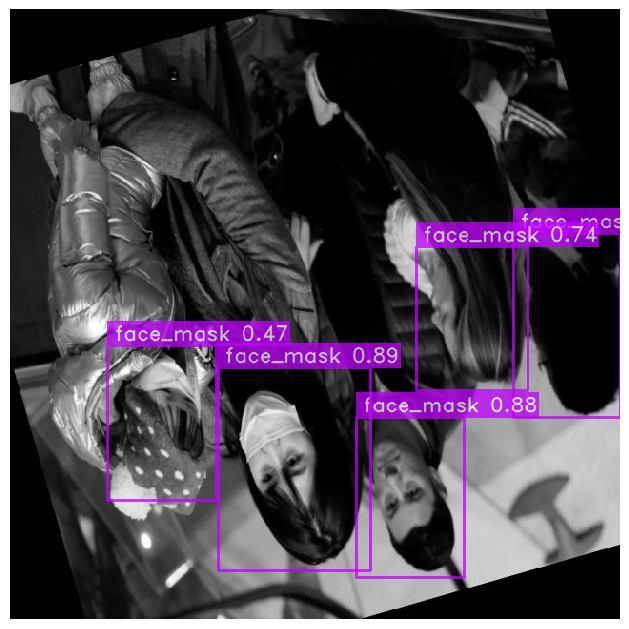

In [36]:
# predicting an image
img_url = '/content/drive/MyDrive/Face_Mask/images/train/face_1.jpg'
best_model.predict(img_url, conf=0.39).show()

[2023-11-05 18:00:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
Exception ignored in: <function WebcamStreaming.__del__ at 0x7a2428ecb910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/media/stream.py", line 70, in __del__
    cv2.destroyAllWindows()
cv2.error: OpenCV(4.8.0) /io/opencv/modules/highgui/src/window.cpp:1266: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'

Exception ignored in: <function WebcamStreaming.__del__ at 0x7a2428ecb910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/media/stream.py", line 70, in __del__
    cv2.destroyA

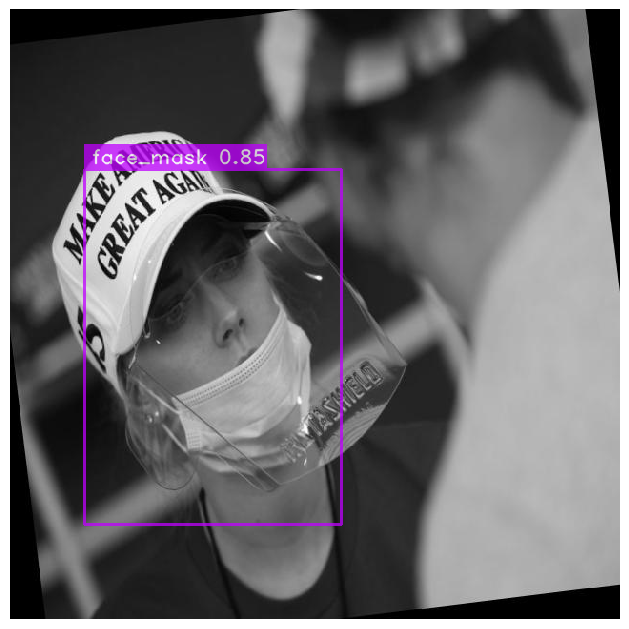

In [53]:
# predicting an image
img_url = '/content/drive/MyDrive/Face_Mask/images/train/face_5.jpg'
best_model.predict(img_url, conf=0.39).show()

[2023-11-05 18:01:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


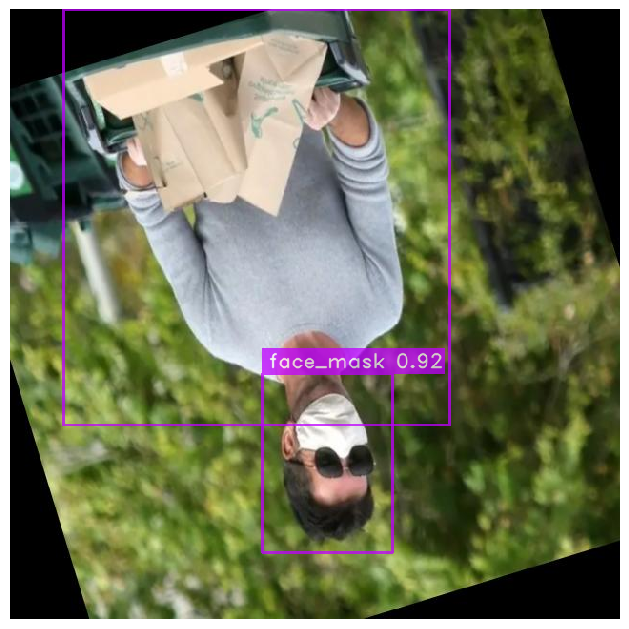

In [54]:
# predicting an image
img_url = '/content/drive/MyDrive/Face_Mask/images/train/face_144.jpg'
best_model.predict(img_url, conf=0.39).show()

In [ ]:
import torch
device = 0 if torch.cuda.is_available() else "cpu"
input_video_path = "/content/drive/MyDrive/mask_new.mp4"
output_video_path = "/content/drive/MyDrive/face_mask_yolonas_l_detections.mp4"
best_model.to(device).predict(input_video_path).save(output_video_path)

In [49]:
import cv2
import torch
from super_gradients.training import models
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

# Create an instance of your YOLO model
# best_model = models.get('yolo_nas_l', num_classes=len(dataset_params['classes']), checkpoint_path='./ckpt_best.pth')

# Move the model to the GPU (if available) or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(device)

# Open a video capture stream for the webcam
cap = cv2.VideoCapture(0)  # Use 0 for the default camera, you can adjust the index if needed

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Perform inference with the model on the frame
    outputs = best_model.predict([frame])  # You may need to adapt this line based on the model's API
    # Process and display the outputs here

    # Display the original frame
    cv2.imshow('Webcam Feed', frame)

    # Exit the loop if the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close the OpenCV windows
cap.release()
# cv2.destroyAllWindows()


In [52]:
best_model = model.to("cuda" if torch.cuda.is_available() else "cpu")

best_model.predict_webcam()
ouputs.show()

ValueError: ignored